# Trivago dataset EDA

## Loading Libraries & Datasets

In [42]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import math
import matplotlib.pyplot as plt
from datetime import datetime
import re
import random

In [40]:
item_metadata_filepath = '../raw_data/item_metadata.csv'
submission_popular_filepath = '../raw_data/submission_popular.csv'
train_filepath = '../raw_data/train.csv'
test_filepath = '../raw_data/test.csv'

In [43]:
submission_popular = pd.read_csv(submission_popular_filepath)
item_metadata = pd.read_csv(item_metadata_filepath)
train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

## Understanding Different Satasets

### test

In [7]:
test[test['session_id'] == '1d688ec168932']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,004A07DM0IDW,1d688ec168932,1541555614,1,interaction item image,2059240,CO,"Santa Marta, Colombia",mobile,NaN,NaN,NaN
1,004A07DM0IDW,1d688ec168932,1541555614,2,interaction item image,2059240,CO,"Santa Marta, Colombia",mobile,NaN,NaN,NaN
2,004A07DM0IDW,1d688ec168932,1541555696,3,clickout item,1050068,CO,"Santa Marta, Colombia",mobile,NaN,2059240|2033381|1724779|127131|399441|103357|1...,70|46|48|76|65|65|106|66|87|43|52|44|60|61|50|...
3,004A07DM0IDW,1d688ec168932,1541555707,4,clickout item,1050068,CO,"Santa Marta, Colombia",mobile,NaN,2059240|2033381|1724779|127131|399441|103357|1...,70|46|48|76|65|65|106|66|87|43|52|44|60|61|50|...
4,004A07DM0IDW,1d688ec168932,1541555717,5,clickout item,1050068,CO,"Santa Marta, Colombia",mobile,NaN,2059240|2033381|1724779|127131|399441|103357|1...,70|46|48|76|65|65|106|66|87|43|52|44|60|61|50|...
5,004A07DM0IDW,1d688ec168932,1541555792,6,clickout item,3241426,CO,"Santa Marta, Colombia",mobile,NaN,2059240|2033381|1724779|127131|399441|103357|1...,70|46|48|76|65|65|106|66|87|43|52|44|60|61|50|...
6,004A07DM0IDW,1d688ec168932,1541555799,7,clickout item,NaN,CO,"Santa Marta, Colombia",mobile,NaN,2059240|2033381|1724779|127131|399441|103357|1...,70|46|48|76|65|65|106|66|87|43|52|44|60|61|50|...


The reference value in the last index is removed, this is the label that the prediction metrics is calculated upon.
The prediction should be on value of the impression list, the metric used to evaluate submissions is mean reciprocal rank.

**Example:**


**query 1:**

impressions = [100, 101, 102, 103, 104, 105]

clicked_item_id = 102

submission = [101, 103, 104, 102, 105, 100]

reciprocal rank = 0.25




**query 2:**

impression = [101, 103, 104, 100, 105]

clicked_item_id = 105

submission = [103, 105, 101, 100, 104]

reciprocal rank = 0.5

mrr = (0.25 + 0.5) / 2 = 0.375

In [15]:
print('Number of unique sessions', test.session_id.nunique(), '.\nNumber of unique sessions that have a clickout',
      test[test.action_type=='clickout item'].session_id.nunique(),'.')

Number of unique sessions 291381 .
Number of unique sessions that have a clickout 275679 .


Clickout here means that there times submissions don't actually have labels. These kinds of sessions should be removed from the datasets as the clickoutout item refers to being a label. A proper function should be handling sessions without any clickouts in the action_type attribute.

### submission_popular

This is the form on how the test set predictions should be submitted.

In [5]:
submission_popular.head()

,user_id,session_id,timestamp,step,item_recommendations
0,000324D9BBUC,89643988fdbfb,1541593942,10,924795 106315 1033140 119494 101758 903037 105...
1,0004Q49X39PY,9de47d9a66494,1541641157,1,3505150 3812004 2227896 2292254 3184842 222702...
2,0004Q49X39PY,beea5c27030cb,1541561202,1,4476010 3505150 3812004 2227896 2292254 222702...
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22854 3067559 22721 22713 16121 22772 22727 22...
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,9857656 5849628 655716 1352530 502066 1405084 ...


In [32]:
submission_popular.dtypes

user_id                 object
session_id              object
timestamp                int64
step                     int64
item_recommendations    object
dtype: object

### item_metadata

In [16]:
item_metadata.head()

,item_id,properties
0,5101,Satellite TV|Golf Course|Airport Shuttle|Cosme...
1,5416,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
2,5834,Satellite TV|Cosmetic Mirror|Safe (Hotel)|Tele...
3,5910,Satellite TV|Sailing|Cosmetic Mirror|Telephone...
4,6066,Satellite TV|Sailing|Diving|Cosmetic Mirror|Sa...


In [14]:
#making sure there is no duplicates
item_metadata.nunique(), len(item_metadata)

(item_id       927142
 properties    566835
 dtype: int64, 927142)

Each item in the different datasets has a number (reference and impression attributes), these items have properties mentioned here.

In [33]:
item_metadata.dtypes

item_id        int64
properties    object
dtype: object

Number of properties can be added as a feature.

### train

In [4]:
train.tail(5)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
15932987,ZYNMLE3MV3LK,62728015bec05,1541544490,15,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932988,ZYNMLE3MV3LK,62728015bec05,1541544491,16,clickout item,6617798,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...
15932989,ZYNMLE3MV3LK,62728015bec05,1541544540,17,clickout item,2712342,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...
15932990,ZYNMLE3MV3LK,62728015bec05,1541544967,18,change of sort order,interaction sort button,PT,"Paris, France",desktop,NaN,NaN,NaN
15932991,ZYNMLE3MV3LK,62728015bec05,1541544973,19,clickout item,1161323,PT,"Paris, France",desktop,Focus on Distance,6617798|1263420|9567886|1161323|149768|1890735...,58|96|55|75|90|60|233|104|150|145|328|207|150|...


In [9]:
train.dtypes

user_id            object
session_id         object
timestamp           int64
step                int64
action_type        object
reference          object
platform           object
city               object
device             object
current_filters    object
impressions        object
prices             object
dtype: object

In [6]:
len(train.columns), train.columns, len(train)

(12, Index(['user_id', 'session_id', 'timestamp', 'step', 'action_type',
        'reference', 'platform', 'city', 'device', 'current_filters',
        'impressions', 'prices'],
       dtype='object'))

In [35]:
#checking which attributes have any NaN
for attribute in train.columns:
  if train[attribute].isna().any():
    print(attribute)

current_filters
impressions
prices


In [12]:
len(train.action_type.unique()), train.action_type.unique()

(10, array(['search for poi', 'interaction item image', 'clickout item',
        'interaction item info', 'interaction item deals',
        'search for destination', 'filter selection',
        'interaction item rating', 'search for item',
        'change of sort order'], dtype=object))

In [36]:
#checking what values in the attribute action_type that gives values in the above attributes
train.dropna().action_type.unique()

array(['clickout item'], dtype=object)

The attributes prices, current_filters, and impressions are not NaN values when the attribute action_type is a clickout item.
The clickout item means that the user had viewed the item in the item's website.

In [37]:
#checking unique numbers of session_id and user_id
train.session_id.nunique(), train.user_id.nunique()

(910683, 730803)

## Creating validation and test sets

Defining function to subset sets

In [44]:
def CreateSubSet(dataset, ratio):
    '''
    Desc: creates smaller set of the main dataset
    
    Input: dataset: Pandas Dataframe with the dataset required to extract smaller dataframe from
           ratio: float between 0 and 1 as a ratio of the size of the main dataset
           
    Output: SubsetDF: Pandas Dataframe with the subset of the main dataset
    '''
    NUniqueSessionsVal = round(len(dataset.session_id.unique().tolist()) * ratio)  #getting the number of unique sessions validation
    print('Number of unique sessions in validation set', NUniqueSessionsVal, '.') #set should be having.

    #unique sessions list
    UnisuqeSessions = dataset.session_id.unique().tolist()

    #set seed
    random.seed(1)

    #randomly selecting sessions_id from train
    SubsetID = list(set(random.choices(dataset.session_id.unique().tolist(), k=NUniqueSessionsVal)))

    #creating dataframe for validation
    SubsetDF = dataset[dataset.session_id.isin(SubsetID)]
    
    #dropping Subset from main dataset
    main = dataset.drop(index=SubsetDF.index)
    
    return SubsetDF, main

##Validation set

Creating a validation set.

In [45]:
val, train = CreateSubSet(train, 0.2)
val.head()

Number of unique sessions in validation set 182137 .


,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
278,0L2TX0JNYVQ6,06e7c29170946,1541041830,1,search for poi,Seoul Station,HK,"Seoul, South Korea",desktop,NaN,NaN,NaN
279,0L2TX0JNYVQ6,06e7c29170946,1541041870,2,clickout item,10091602,HK,"Seoul, South Korea",desktop,NaN,2802232|2733571|5477718|155374|155465|3549258|...,124|176|99|220|191|127|85|54|83|268|78|144|96|...
280,0L2TX0JNYVQ6,06e7c29170946,1541041882,3,interaction item deals,10091602,HK,"Seoul, South Korea",desktop,NaN,NaN,NaN
281,0L2TX0JNYVQ6,06e7c29170946,1541044143,4,search for poi,Myeongdong,HK,"Seoul, South Korea",desktop,NaN,NaN,NaN
282,0L2TX0JNYVQ6,06e7c29170946,1541044151,5,clickout item,10091602,HK,"Seoul, South Korea",desktop,NaN,3549258|155465|155374|363046|3954788|4773608|3...,135|189|219|78|74|135|95|85|176|99|108|83|87|3...


##Test set

Creating a new test set

In [46]:
test, train = CreateSubSet(train, 0.2)
test.head()

Number of unique sessions in validation set 149151 .


,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
239,0IVOT7X0FJWE,554392be66854,1541044445,1,interaction item rating,9167996,BR,"Parnaíba, Brazil",mobile,NaN,NaN,NaN
240,0IVOT7X0FJWE,554392be66854,1541044448,2,clickout item,9167996,BR,"Parnaíba, Brazil",mobile,NaN,2035675|4095738|4933410|9167996,225|23|58|53
241,0IVOT7X0FJWE,554392be66854,1541044519,3,interaction item image,9167996,BR,"Parnaíba, Brazil",mobile,NaN,NaN,NaN
242,0IVOT7X0FJWE,554392be66854,1541044519,4,interaction item image,9167996,BR,"Parnaíba, Brazil",mobile,NaN,NaN,NaN
243,0IVOT7X0FJWE,554392be66854,1541044529,5,interaction item image,9167996,BR,"Parnaíba, Brazil",mobile,NaN,NaN,NaN


##Train Data Exploration

Clear Cache memory a bit and load only train data

In [49]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


###Columns

In [68]:
train.columns

Index(['user_id', 'session_id', 'timestamp', 'step', 'action_type',
       'reference', 'platform', 'city', 'device', 'current_filters',
       'impressions', 'prices'],
      dtype='object')

In [69]:
#Numbers
print('number of unique users :', train.user_id.nunique())
print('number of unique sessions :', train.session_id.nunique())

number of unique users : 617354
number of unique sessions : 745755


Previous preferences can be detirmined from older sessions.

###Steps per Session

The attribute step tracks down the interactions made by the user.

{'boxes': [<matplotlib.lines.Line2D at 0x7f87ba41da90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f87ba371668>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f87ba2fb080>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f87ba371cf8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f87ba361f98>,
  <matplotlib.lines.Line2D at 0x7f87ba371320>]}

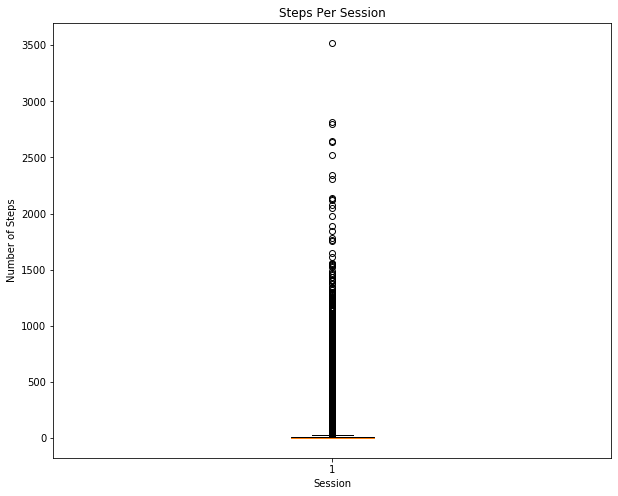

In [74]:
plt.figure(figsize=(10,8))
plt.title('Steps Per Session')
plt.xlabel('Session')
plt.ylabel('Number of Steps')
plt.boxplot(train.groupby('session_id').step.max().values)

(array([7.43264e+05, 2.08300e+03, 2.99000e+02, 7.50000e+01, 1.60000e+01,
        7.00000e+00, 5.00000e+00, 5.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.0000e+00, 3.5310e+02, 7.0520e+02, 1.0573e+03, 1.4094e+03,
        1.7615e+03, 2.1136e+03, 2.4657e+03, 2.8178e+03, 3.1699e+03,
        3.5220e+03]),
 <a list of 10 Patch objects>)

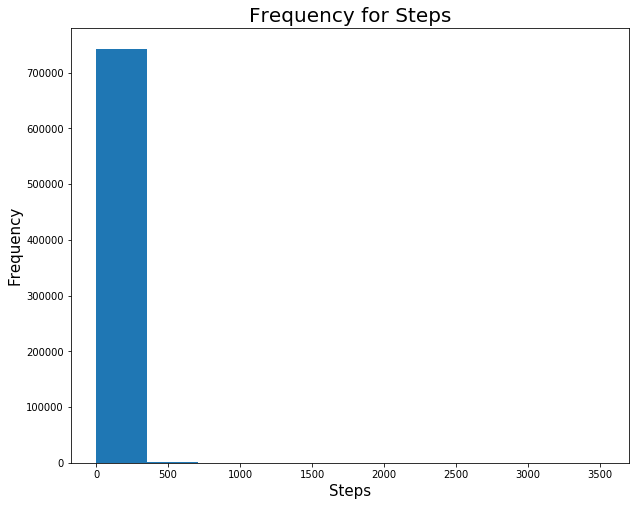

In [5]:
#In other words
plt.figure(figsize=(10,8))
plt.title('Frequency for Steps', fontsize=20)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.hist(train.groupby('session_id').step.max().values, bins=10)

Sessions that are high in steps are computational overhead and don't have valuable information.
One of the outliers has around 3500 steps in just one session.

A preprocessing function of removing sessions with high number of steps is needed.

In [77]:
#investigating this type of sessions
train[train.step > 3000].tail(1)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
9447211,6JWWFFNUMY6Y,3167404ed3197,1541368776,3522,interaction item rating,36455,TR,"Ankara, Turkey",mobile,NaN,NaN,NaN


In [78]:
train[train.session_id == '3167404ed3197'][train.action_type == 'clickout item']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
9444357,6JWWFFNUMY6Y,3167404ed3197,1541367828,668,clickout item,1819737,TR,"Ankara, Turkey",mobile,Breakfast Included,933451|6365508|6533954|107368|36455|151827|364...,33|32|40|17|26|23|33|36|42|42|26|43|22|29|38|4...


###Number of Clickouts/Session

(array([412391., 135390.,  56690.,  28670.,      0.,  15221.,   9240.,
          5669.,   3918.,   2413.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

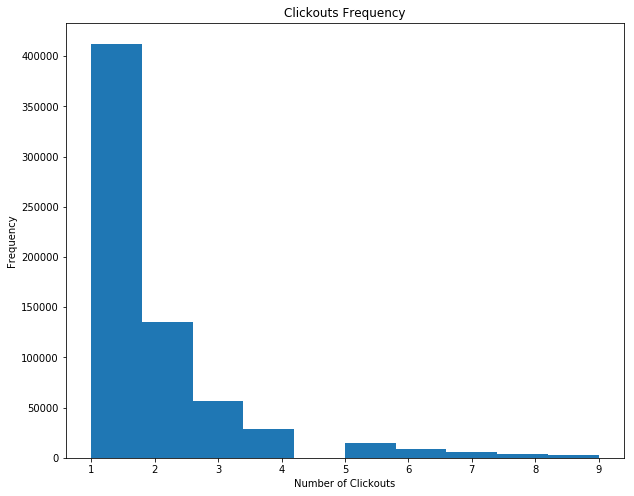

In [73]:
NClickoutSession = train[train.action_type=='clickout item'].groupby('session_id', sort=False).action_type.count()

#creating a dataframe of session_id and NumberOfClickouts
NClickoutSessionDF = NClickoutSession.to_frame()
NClickoutSessionDF.reset_index(level=0, inplace=True)
NClickoutSessionDF = NClickoutSessionDF.rename(columns={'action_type':'NumberOfClickouts'})

#removing sessions with more than 9 clickouts to have number of clickouts histogram
plt.figure(figsize=(10, 8))
plt.title('Clickouts Frequency')
plt.xlabel('Number of Clickouts')
plt.ylabel('Frequency')
plt.hist(NClickoutSessionDF[NClickoutSessionDF.NumberOfClickouts<10].NumberOfClickouts)

Sessions with just one clickout is the majority.

define a function that removes word values from the reference attribute for further need in EDA and Feature Engineering.

In [84]:
# remove na ***
def RemoveNonItemValues(dataset):
    dataset.reference = dataset.reference.apply(lambda x: pd.to_numeric(x, errors='coerce')).\
    dropna().astype(int).apply(lambda x: str(x))
    return

In [0]:
#removing reference values that are not items
ItemsOneClickout = OneClickoutDF.reference.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna().astype(int).apply(lambda x: str(x))

In [12]:
OneClickoutDF.reference.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna().astype(int).apply(lambda x: str(x))

81          2795374
82          2795374
83          2795374
84          2795374
85          2795374
             ...   
13019529    3811156
13019530    3811156
13019532     149585
13019533     149585
13019534    8985292
Name: reference, Length: 4209981, dtype: object

###Ranks & Prices

A function that converts impressions into a list of items, and prices into a list of integers that represent prices of these items.

The list of items is in order of the ranks given by Trivago, and the same applies to the prices.

In [0]:
def impression_price(session_id):               #the isssue with this function is that ignores the first clickouts(there are valuable infromation that can be extracted)
  try:                                          #some of the functions don't apply on the some sessions
    impression = train[train.session_id == session_id][train.action_type == 'clickout item'].tail(1).impressions.values[0].split('|')
    price = train[train.session_id == session_id][train.action_type == 'clickout item'].tail(1).prices.values[0].split('|')
    price = list(map(int, price))               #converting list of strings into integers
    clickout_item = train[train.session_id == session_id][train.action_type == 'clickout item'].tail(1).reference.values[0]
    all_interacted_with_items = train[train.session_id == session_id].reference.unique().tolist()
    
    for i in range(len(impression)):            #getting the clickout item
      if clickout_item == impression[i]:
        rank = i
    
    interacted_with_items = []
    interacted_with_items_prices = []
    for item in all_interacted_with_items:      #getting interacted with items
      for i in range(len(impression)):
        if item == impression[i]:
          interacted_with_items.append(item)
          interacted_with_items_prices.append(price[i])
                                                #plotting the output
    plt.figure(figsize=(10,8))
    plt.title('Impressions and Prices', fontsize=30)
    plt.xlabel('Impressions', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.xticks(rotation=90)                     #Interacted with items are in red points
    plt.plot(impression, price, 'o')            #Final clickout item is in black
    plt.plot(interacted_with_items, interacted_with_items_prices, 'o', color='red')
    plt.plot(clickout_item, price[rank] , 'o', color='black')
  except:
    pass  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_laun

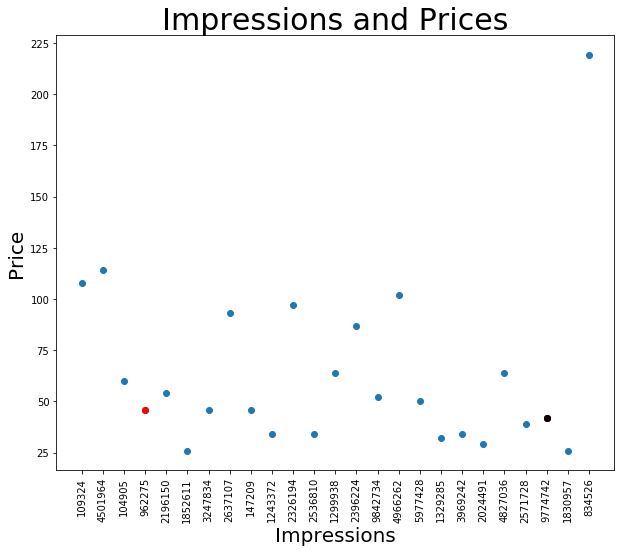

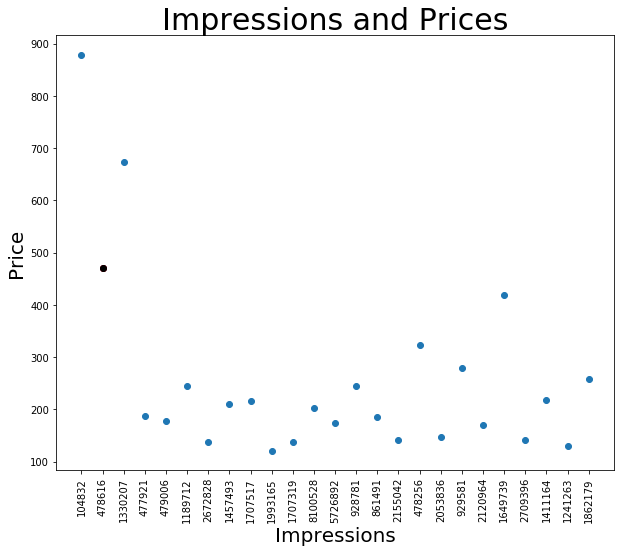

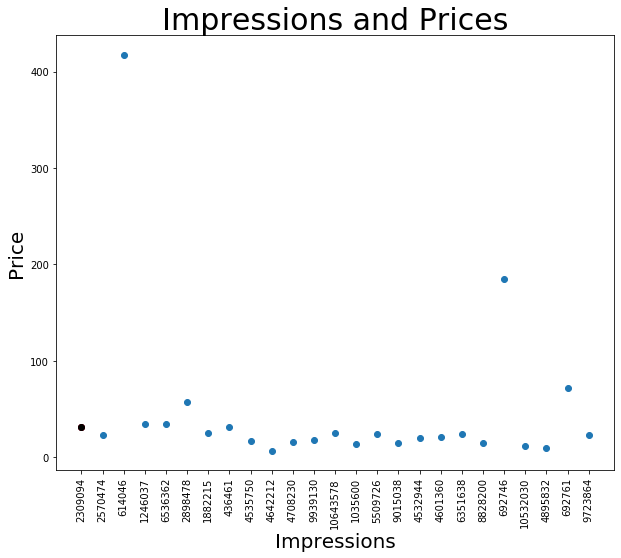

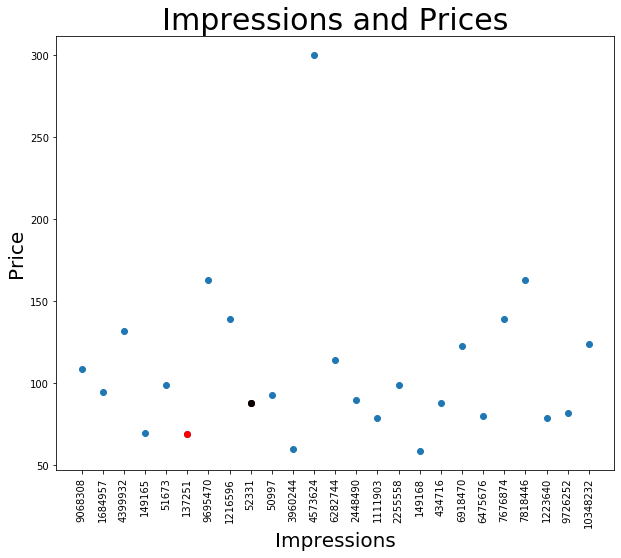

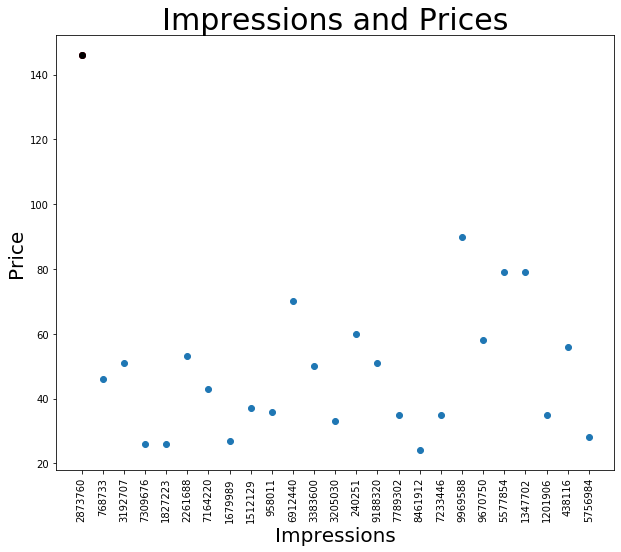

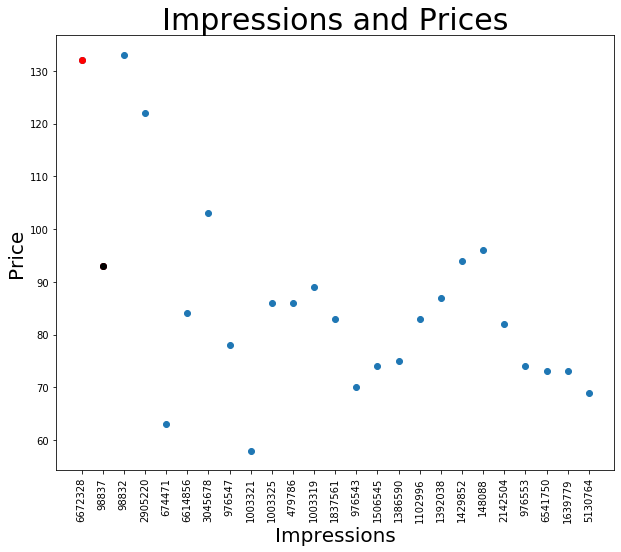

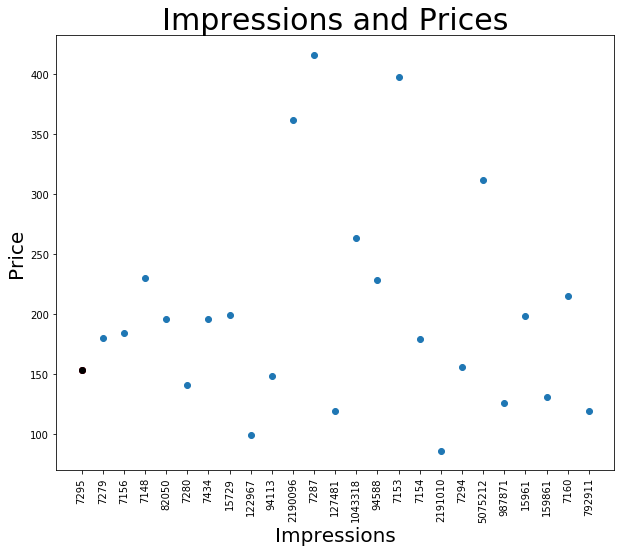

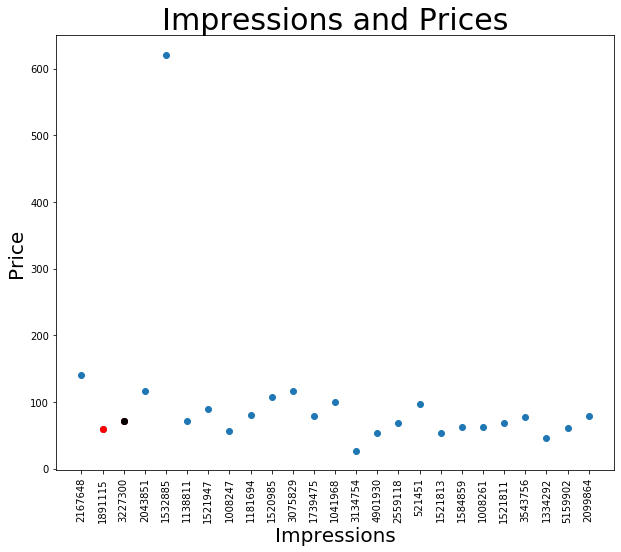

In [146]:
listOfSessions = random.choices(train.session_id.unique(), k=10)
for session_id in listOfSessions:
  impression_price(session_id)

Prices and Ranks are originaly can have an effect on the user choice. These two should be features.

###Time Spent

###Total Time Spent

In [17]:
#getting the time spent in each session in seconds
TotalTimeSpentPerSession = train.groupby('session_id').timestamp.last() - train.groupby('session_id').timestamp.first()
TotalTimeSpentPerSession

session_id
00000510f1adc      0
00003f3b20954      0
000056cd97ce2    255
000066611146f     25
00008c1f39c46    200
                ... 
tpc71ussgcuou      0
u5e4la6f115r1      0
udmhn71cn8500    237
v9815m0bctrm1      0
vg1t2qc04afrt     14
Name: timestamp, Length: 745755, dtype: int64

In [52]:
#checking for the values
TotalTimeSpentPerSession.min()

-270818

The minimum value should be 0 (since it is time spent) That shows that something is not consistent in the dataset.

For now, I'll use another functions to get through this, but some of the sessions' steps(rows) for some reason don't lie where it is supposed to be as mentioned in the next cell.

In [60]:
train[train.session_id=='8c41f0b873b0b'].head(2)

,Unnamed: 0,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
975662,1190260,PBIZWRQOUBVE,8c41f0b873b0b,1541544799,1,clickout item,928649,TR,"Istanbul, Turkey",desktop,NaN,928649|2786846|927845|2631584|4414636|37539|98...,129|87|111|167|42|116|71|36|45|80|71|40|45|50|...
8432290,10308397,PBIZWRQOUBVE,8c41f0b873b0b,1541273844,1,interaction item image,4584962,TR,"Istanbul, Turkey",desktop,NaN,NaN,NaN


In [62]:
#using max and min functions instead
TotalTimeSpentPerSession = train.groupby('session_id').timestamp.max() - train.groupby('session_id').timestamp.min()
TotalTimeSpentPerSession.min()

0

{'boxes': [<matplotlib.lines.Line2D at 0x7f7fd5561e48>],
 'caps': [<matplotlib.lines.Line2D at 0x7f7fd556d8d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7fd55792e8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f7fd556df60>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f7fd5561f98>,
  <matplotlib.lines.Line2D at 0x7f7fd556d588>]}

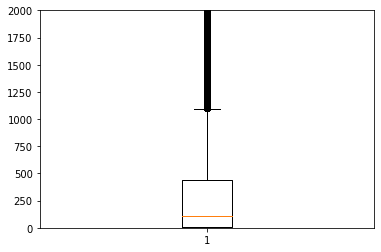

In [76]:
plt.ylim(0, 2000)
plt.boxplot(TotalTimeSpentPerSession)

In [80]:
#percentage of time spent more than the maximum
round((TotalTimeSpentPerSession[TotalTimeSpentPerSession>1140].count()/TotalTimeSpentPerSession.count())*100,2) 

11.57

TotalSecondsSpent should be a feature.

###ReferenceTimeSpent

ReferenceTrain set should be added in Feature Engineering. It will help in getting information about different references in a session.

In [101]:
train.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [111]:
#loading train set
ReferenceTrain = pd.read_csv('/content/drive/My Drive/Trivago/Clean Dataset/train.csv')
ReferenceTrain = ReferenceTrain.drop(columns='Unnamed: 0')

#converting words values in referenc into NaN
ReferenceTrain.reference = ReferenceTrain.reference.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna().astype(int).apply(lambda x: str(x))

#dropping NaN in reference
ReferenceTrain = ReferenceTrain.drop(ReferenceTrain[ReferenceTrain.reference.isna()].index.tolist())

#what I meant by the previous step
train.reference, ReferenceTrain.reference

(0                           Newtown
 1                            666856
 2                            666856
 3                            666856
 4                            109038
                      ...           
 13019551                    6617798
 13019552                    6617798
 13019553                    2712342
 13019554    interaction sort button
 13019555                    1161323
 Name: reference, Length: 13019556, dtype: object, 1            666856
 2            666856
 3            666856
 4            109038
 5            666856
              ...   
 13019550    6617798
 13019551    6617798
 13019552    6617798
 13019553    2712342
 13019555    1161323
 Name: reference, Length: 11679717, dtype: object)

In [115]:
ReferenceTimeSpent = (ReferenceTrain.groupby(['session_id', 'reference']).timestamp.max() 
                      - ReferenceTrain.groupby(['session_id', 'reference']).timestamp.min())
ReferenceTimeSpent

session_id     reference
00000510f1adc  7281198        0
00003f3b20954  979325         0
000056cd97ce2  2784325        0
               3811810      227
000066611146f  5479306        0
                           ... 
u5e4la6f115r1  147574         0
udmhn71cn8500  4283966       73
               5030808        0
v9815m0bctrm1  157502         0
vg1t2qc04afrt  4905934        0
Name: timestamp, Length: 1698848, dtype: int64

In [0]:
ReferenceTrain.to_csv('train_ref.csv')                  #DO NOT RUN BEFORE INVESTIGATING FOR THE BEST PRACTICES
!cp train_ref.csv '/content/drive/My Drive/Trivago/Clean Dataset/'

Reference Time Spent should be a feature.
Removing words function or Regex function should be incluced in Feature Engineering.